# Wireless Channel Simulator - Complete Implementation


---

## Project Overview

Monte Carlo simulation of digital wireless communication systems comparing **BPSK, QPSK, and 16-QAM** modulation schemes over **AWGN and Rayleigh fading** channels.

### Key Features:
- **3 Modulation Schemes:** BPSK, QPSK, 16-QAM (Gray-coded)
- **2 Channel Models:** AWGN, Rayleigh Fading with Perfect CSI
- **100,000 bits per test** for statistical robustness
- BER vs SNR analysis
- Constellation diagram visualization

### Technologies:
Python, NumPy, SciPy, Matplotlib

---

## Cell 1: Import Libraries

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries loaded successfully!")
print("=" * 60)

All libraries loaded successfully!


## Cell 2: Modulation Functions

Implementation of three digital modulation schemes:
- **BPSK:** 1 bit per symbol (most robust)
- **QPSK:** 2 bits per symbol (medium efficiency)
- **16-QAM:** 4 bits per symbol (highest data rate, Gray-coded)

In [2]:
def bpsk_modulate(bits):
    """
    BPSK (Binary Phase Shift Keying) Modulation
    Maps: 0 → -1, 1 → +1
    
    Args:
        bits: Binary array (0s and 1s)
    Returns:
        symbols: BPSK modulated symbols
    """
    symbols = 2 * bits - 1
    return symbols.astype(float)


def qpsk_modulate(bits):
    """
    QPSK (Quadrature Phase Shift Keying) Modulation
    Maps 2 bits to 1 complex symbol
    Normalized by sqrt(2) for unit average energy
    
    Args:
        bits: Binary array
    Returns:
        symbols: QPSK modulated complex symbols
    """
    # Ensure even number of bits
    if len(bits) % 2 != 0:
        bits = np.append(bits, 0)
    
    bits_reshaped = bits.reshape(-1, 2)
    symbols = np.zeros(len(bits_reshaped), dtype=complex)
    
    for i, (b1, b2) in enumerate(bits_reshaped):
        real_part = 2 * b1 - 1  # Maps 0→-1, 1→+1
        imag_part = 2 * b2 - 1  # Maps 0→-1, 1→+1
        symbols[i] = (real_part + 1j * imag_part) / np.sqrt(2)
    
    return symbols


def qam16_modulate(bits):
    """
    16-QAM (16 Quadrature Amplitude Modulation)
    Maps 4 bits to 1 complex symbol using Gray coding
    Normalized by sqrt(10) for unit average energy
    
    Gray coding minimizes bit errors between adjacent constellation points
    
    Args:
        bits: Binary array
    Returns:
        symbols: 16-QAM modulated complex symbols
    """
    # Pad bits to make length divisible by 4
    num_bits = len(bits)
    pad_bits = (4 - num_bits % 4) % 4
    if pad_bits > 0:
        bits = np.append(bits, np.zeros(pad_bits, dtype=int))
    
    bits_reshaped = bits.reshape(-1, 4)
    symbols = np.zeros(len(bits_reshaped), dtype=complex)
    
    # Gray-coded 16-QAM constellation mapping
    # Organized to minimize bit errors between adjacent points
    constellation_map = {
        (0, 0, 0, 0): -3 - 3j, (0, 0, 0, 1): -3 - 1j, (0, 0, 1, 1): -3 + 3j, (0, 0, 1, 0): -3 + 1j,
        (0, 1, 0, 0): -1 - 3j, (0, 1, 0, 1): -1 - 1j, (0, 1, 1, 1): -1 + 3j, (0, 1, 1, 0): -1 + 1j,
        (1, 1, 0, 0):  3 - 3j, (1, 1, 0, 1):  3 - 1j, (1, 1, 1, 1):  3 + 3j, (1, 1, 1, 0):  3 + 1j,
        (1, 0, 0, 0):  1 - 3j, (1, 0, 0, 1):  1 - 1j, (1, 0, 1, 1):  1 + 3j, (1, 0, 1, 0):  1 + 1j,
    }
    
    for i, four_bits in enumerate(bits_reshaped):
        key = tuple(four_bits)
        symbols[i] = constellation_map[key]
    
    # Normalize for unit average energy
    symbols = symbols / np.sqrt(10)
    
    return symbols


print("Modulation functions defined")
print(" - BPSK: 1 bit per symbol")
print(" - QPSK: 2 bits per symbol")
print(" - 16-QAM: 4 bits per symbol (Gray-coded)")

Modulation functions defined
 - BPSK: 1 bit per symbol
 - QPSK: 2 bits per symbol
 - 16-QAM: 4 bits per symbol (Gray-coded)


## Cell 3: Channel Models

Two wireless channel implementations:
- **AWGN:** Additive White Gaussian Noise (ideal baseline channel)
- **Rayleigh Fading:** Multipath propagation (realistic urban/indoor environment)
  - Assumes **Perfect Channel State Information (CSI)** for coherent detection
  - Perfect channel compensation applied at receiver

In [3]:
def add_awgn(symbols, snr_db):
    """
    Add Additive White Gaussian Noise to symbols
    
    Args:
        symbols: Modulated symbols (real or complex)
        snr_db: Signal-to-Noise Ratio in dB
    Returns:
        noisy_symbols: Symbols with added AWGN
    """
    snr_linear = 10 ** (snr_db / 10.0)
    signal_power = np.mean(np.abs(symbols) ** 2)
    noise_power = signal_power / snr_linear
    
    if np.iscomplexobj(symbols):
        # Complex noise: independent real and imaginary components
        noise = (np.random.randn(len(symbols)) + 
                 1j * np.random.randn(len(symbols))) * np.sqrt(noise_power / 2)
    else:
        # Real noise
        noise = np.random.randn(len(symbols)) * np.sqrt(noise_power)
    
    return symbols + noise


def add_rayleigh_fading(symbols, snr_db):
    """
    Add Rayleigh Fading + AWGN to symbols
    Simulates multipath propagation effects with Perfect CSI
    
    Perfect CSI Assumption:
    - Receiver has exact knowledge of channel coefficients h
    - Enables perfect channel compensation (zero-forcing equalization)
    - Realistic for systems with pilot-aided channel estimation
    
    Args:
        symbols: Modulated symbols
        snr_db: Signal-to-Noise Ratio in dB
    Returns:
        compensated_symbols: Faded + noisy symbols after perfect compensation
    """
    # Generate Rayleigh fading coefficients (complex Gaussian)
    h_real = np.random.randn(len(symbols))
    h_imag = np.random.randn(len(symbols))
    h = (h_real + 1j * h_imag) / np.sqrt(2)  # Normalized Rayleigh
    
    # Apply fading
    faded_symbols = symbols * h
    
    # Add AWGN after fading
    snr_linear = 10 ** (snr_db / 10.0)
    signal_power = np.mean(np.abs(faded_symbols) ** 2)
    noise_power = signal_power / snr_linear
    
    if np.iscomplexobj(symbols):
        noise = (np.random.randn(len(symbols)) + 
                 1j * np.random.randn(len(symbols))) * np.sqrt(noise_power / 2)
    else:
        noise = np.random.randn(len(symbols)) * np.sqrt(noise_power)
    
    noisy_faded_symbols = faded_symbols + noise
    
    # Perfect channel compensation (Perfect CSI)
    # Small epsilon prevents division by zero for deep fades
    compensated_symbols = noisy_faded_symbols / (h + 1e-10)
    
    return compensated_symbols


print("Channel models defined")
print(" - AWGN: Ideal channel with additive noise")
print(" - Rayleigh Fading: Realistic multipath channel (Perfect CSI)")

Channel models defined
 - AWGN: Ideal channel with additive noise
 - Rayleigh Fading: Realistic multipath channel (Perfect CSI)


## Cell 4: Demodulation Functions

Hard decision demodulation for all three modulation schemes

In [4]:
def bpsk_demodulate(symbols):
    """
    BPSK Demodulation
    Decision rule: symbol > 0 → bit=1, else bit=0
    
    Args:
        symbols: Received BPSK symbols
    Returns:
        bits: Demodulated binary array
    """
    return (np.real(symbols) > 0).astype(int)


def qpsk_demodulate(symbols):
    """
    QPSK Demodulation
    Separate decision for real and imaginary components
    
    Args:
        symbols: Received QPSK symbols
    Returns:
        bits: Demodulated binary array
    """
    bits = np.zeros(len(symbols) * 2, dtype=int)
    
    for i, symbol in enumerate(symbols):
        bits[2 * i]     = 1 if symbol.real > 0 else 0
        bits[2 * i + 1] = 1 if symbol.imag > 0 else 0
    
    return bits


def qam16_demodulate(symbols):
    """
    16-QAM Demodulation
    Minimum Euclidean distance detection with Gray-coded constellation
    
    Args:
        symbols: Received 16-QAM symbols
    Returns:
        bits: Demodulated binary array
    """
    # Denormalize symbols
    symbols = symbols * np.sqrt(10)
    
    # Gray-coded constellation (same as modulation)
    constellation_map = {
        (0, 0, 0, 0): -3 - 3j, (0, 0, 0, 1): -3 - 1j, (0, 0, 1, 1): -3 + 3j, (0, 0, 1, 0): -3 + 1j,
        (0, 1, 0, 0): -1 - 3j, (0, 1, 0, 1): -1 - 1j, (0, 1, 1, 1): -1 + 3j, (0, 1, 1, 0): -1 + 1j,
        (1, 1, 0, 0):  3 - 3j, (1, 1, 0, 1):  3 - 1j, (1, 1, 1, 1):  3 + 3j, (1, 1, 1, 0):  3 + 1j,
        (1, 0, 0, 0):  1 - 3j, (1, 0, 0, 1):  1 - 1j, (1, 0, 1, 1):  1 + 3j, (1, 0, 1, 0):  1 + 1j,
    }
    
    bits = []
    
    for symbol in symbols:
        min_distance = float('inf')
        decoded_bits = None
        
        # Find nearest constellation point
        for bit_pattern, ideal_symbol in constellation_map.items():
            distance = abs(symbol - ideal_symbol)
            if distance < min_distance:
                min_distance = distance
                decoded_bits = bit_pattern
        
        bits.extend(decoded_bits)
    
    return np.array(bits, dtype=int)


print("Demodulation functions defined")
print(" - BPSK: Hard decision on real axis")
print(" - QPSK: Independent I/Q hard decisions")
print(" - 16-QAM: Minimum distance decoder")

Demodulation functions defined
 - BPSK: Hard decision on real axis
 - QPSK: Independent I/Q hard decisions
 - 16-QAM: Minimum distance decoder


## Cell 5: BER Calculation

In [5]:
def calculate_ber(tx_bits, rx_bits):
    """
    Calculate Bit Error Rate (BER)
    BER = Number of bit errors / Total bits
    
    Args:
        tx_bits: Transmitted bits
        rx_bits: Received (demodulated) bits
    Returns:
        ber: Bit Error Rate
    """
    min_len = min(len(tx_bits), len(rx_bits))
    tx_bits = tx_bits[:min_len]
    rx_bits = rx_bits[:min_len]
    
    errors = np.sum(tx_bits != rx_bits)
    ber = errors / len(tx_bits)
    
    return ber


print("BER calculation function defined")

BER calculation function defined


## Cell 6: Complete Simulation

Simulating:
- 3 modulations × 2 channels × 11 SNR points
- 100,000 bits per test
- **Total: 6.6 million bit transmissions**

In [6]:
def simulate_complete_system(num_bits=100000, snr_range_db=np.arange(0, 21, 2)):
    """
    Run complete wireless system simulation
    
    Args:
        num_bits: Number of bits per test point
        snr_range_db: Array of SNR values in dB
    Returns:
        snr_range_db: SNR values
        results: Dictionary containing BER results for all configurations
    """
    print("\n" + "=" * 70)
    print(" " * 10 + "COMPLETE WIRELESS CHANNEL SIMULATION")
    print("=" * 70)
    print(f"Number of bits: {num_bits:,}")
    print(f"SNR range: {snr_range_db[0]} to {snr_range_db[-1]} dB")
    print(f"Modulations: BPSK, QPSK, 16-QAM")
    print(f"Channels: AWGN, Rayleigh Fading (Perfect CSI)")
    print("=" * 70)
    
    results = {
        'AWGN': {'BPSK': [], 'QPSK': [], '16-QAM': []},
        'Rayleigh': {'BPSK': [], 'QPSK': [], '16-QAM': []}
    }
    
    for snr_db in snr_range_db:
        print(f"\nTesting SNR = {snr_db} dB...")
        
        # ==================== AWGN Channel ====================
        print("  AWGN Channel:")
        
        # BPSK
        tx_bits = np.random.randint(0, 2, num_bits)
        tx_symbols = bpsk_modulate(tx_bits)
        rx_symbols = add_awgn(tx_symbols, snr_db)
        rx_bits = bpsk_demodulate(rx_symbols)
        ber = calculate_ber(tx_bits, rx_bits)
        results['AWGN']['BPSK'].append(ber)
        print(f"    BPSK:   BER = {ber:.6f}")
        
        # QPSK
        tx_bits = np.random.randint(0, 2, num_bits)
        tx_symbols = qpsk_modulate(tx_bits)
        rx_symbols = add_awgn(tx_symbols, snr_db)
        rx_bits = qpsk_demodulate(rx_symbols)
        ber = calculate_ber(tx_bits[:len(rx_bits)], rx_bits)
        results['AWGN']['QPSK'].append(ber)
        print(f"    QPSK:   BER = {ber:.6f}")
        
        # 16-QAM
        tx_bits = np.random.randint(0, 2, num_bits)
        tx_symbols = qam16_modulate(tx_bits)
        rx_symbols = add_awgn(tx_symbols, snr_db)
        rx_bits = qam16_demodulate(rx_symbols)
        ber = calculate_ber(tx_bits[:len(rx_bits)], rx_bits)
        results['AWGN']['16-QAM'].append(ber)
        print(f"    16-QAM: BER = {ber:.6f}")
        
        # ==================== Rayleigh Fading Channel ====================
        print("  Rayleigh Fading Channel:")
        
        # BPSK
        tx_bits = np.random.randint(0, 2, num_bits)
        tx_symbols = bpsk_modulate(tx_bits)
        rx_symbols = add_rayleigh_fading(tx_symbols, snr_db)
        rx_bits = bpsk_demodulate(rx_symbols)
        ber = calculate_ber(tx_bits, rx_bits)
        results['Rayleigh']['BPSK'].append(ber)
        print(f"    BPSK:   BER = {ber:.6f}")
        
        # QPSK
        tx_bits = np.random.randint(0, 2, num_bits)
        tx_symbols = qpsk_modulate(tx_bits)
        rx_symbols = add_rayleigh_fading(tx_symbols, snr_db)
        rx_bits = qpsk_demodulate(rx_symbols)
        ber = calculate_ber(tx_bits[:len(rx_bits)], rx_bits)
        results['Rayleigh']['QPSK'].append(ber)
        print(f"    QPSK:   BER = {ber:.6f}")
        
        # 16-QAM
        tx_bits = np.random.randint(0, 2, num_bits)
        tx_symbols = qam16_modulate(tx_bits)
        rx_symbols = add_rayleigh_fading(tx_symbols, snr_db)
        rx_bits = qam16_demodulate(rx_symbols)
        ber = calculate_ber(tx_bits[:len(rx_bits)], rx_bits)
        results['Rayleigh']['16-QAM'].append(ber)
        print(f"    16-QAM: BER = {ber:.6f}")
    
    print("\n" + "=" * 70)
    print("SIMULATION COMPLETE!")
    print("=" * 70)
    
    return snr_range_db, results


# Run simulation
snr_vals, all_results = simulate_complete_system()


          COMPLETE WIRELESS CHANNEL SIMULATION
Number of bits: 100,000
SNR range: 0 to 20 dB
Modulations: BPSK, QPSK, 16-QAM
Channels: AWGN, Rayleigh Fading (Perfect CSI)

Testing SNR = 0 dB...
  AWGN Channel:
    BPSK:   BER = 0.158260
    QPSK:   BER = 0.158330
    16-QAM: BER = 0.308030
  Rayleigh Fading Channel:
    BPSK:   BER = 0.125650
    QPSK:   BER = 0.211170
    16-QAM: BER = 0.330050

Testing SNR = 2 dB...
  AWGN Channel:
    BPSK:   BER = 0.104800
    QPSK:   BER = 0.104410
    16-QAM: BER = 0.274570
  Rayleigh Fading Channel:
    BPSK:   BER = 0.096250
    QPSK:   BER = 0.169820
    16-QAM: BER = 0.298750

Testing SNR = 4 dB...
  AWGN Channel:
    BPSK:   BER = 0.056800
    QPSK:   BER = 0.056480
    16-QAM: BER = 0.235990
  Rayleigh Fading Channel:
    BPSK:   BER = 0.069920
    QPSK:   BER = 0.125720
    16-QAM: BER = 0.263200

Testing SNR = 6 dB...
  AWGN Channel:
    BPSK:   BER = 0.022560
    QPSK:   BER = 0.022560
    16-QAM: BER = 0.187440
  Rayleigh Fading Channe

## Cell 7: BER vs SNR Plots

Generate BER performance curves


BER curves saved as 'Complete_BER_Analysis.png'


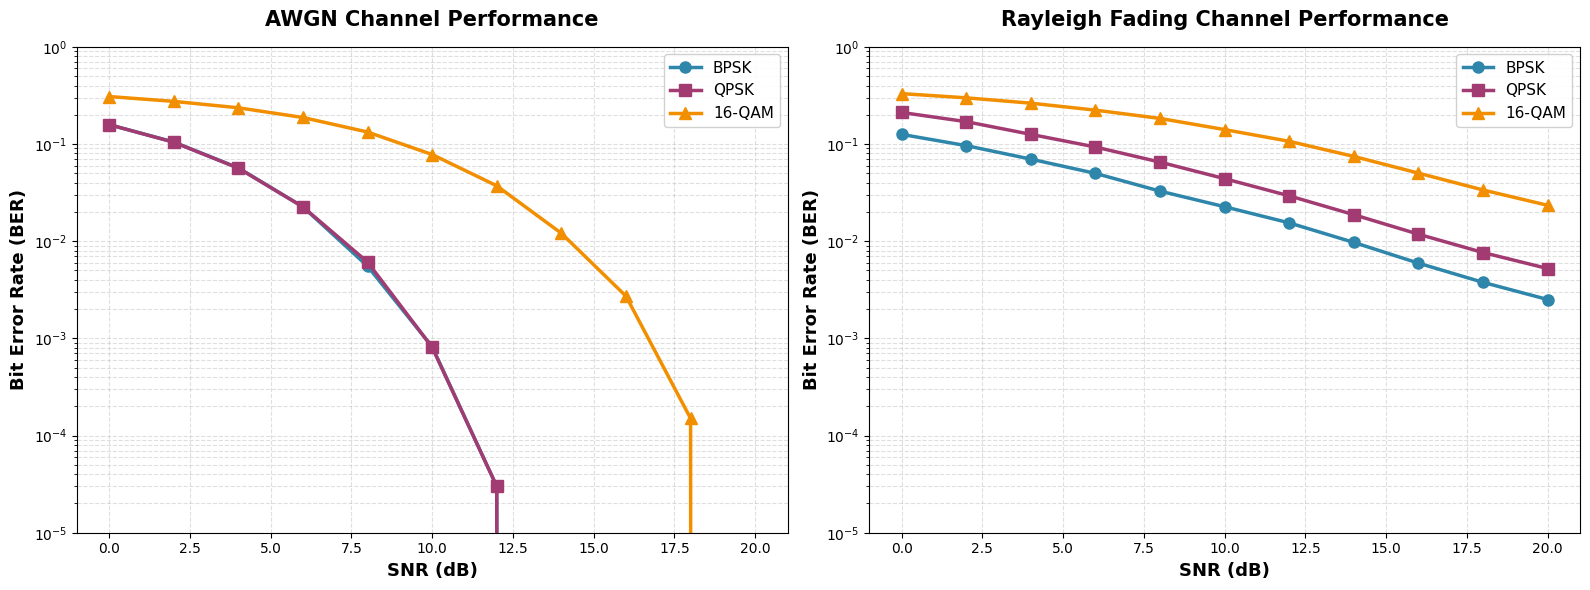

In [7]:
def plot_complete_ber_curves(snr_range, results):
    """
    Create BER vs SNR plots for both channels
    
    Args:
        snr_range: Array of SNR values
        results: Dictionary containing BER results
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ==================== AWGN Channel ====================
    ax1.semilogy(snr_range, results['AWGN']['BPSK'], 'o-',
                 linewidth=2.5, markersize=8, label='BPSK', color='#2E86AB')
    ax1.semilogy(snr_range, results['AWGN']['QPSK'], 's-',
                 linewidth=2.5, markersize=8, label='QPSK', color='#A23B72')
    ax1.semilogy(snr_range, results['AWGN']['16-QAM'], '^-',
                 linewidth=2.5, markersize=8, label='16-QAM', color='#F18F01')
    
    ax1.set_xlabel('SNR (dB)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Bit Error Rate (BER)', fontsize=13, fontweight='bold')
    ax1.set_title('AWGN Channel Performance', fontsize=15, fontweight='bold', pad=15)
    ax1.grid(True, which='both', linestyle='--', alpha=0.4)
    ax1.legend(fontsize=11, loc='upper right', framealpha=0.9)
    ax1.set_ylim([1e-5, 1])
    
    # ==================== Rayleigh Fading Channel ====================
    ax2.semilogy(snr_range, results['Rayleigh']['BPSK'], 'o-',
                 linewidth=2.5, markersize=8, label='BPSK', color='#2E86AB')
    ax2.semilogy(snr_range, results['Rayleigh']['QPSK'], 's-',
                 linewidth=2.5, markersize=8, label='QPSK', color='#A23B72')
    ax2.semilogy(snr_range, results['Rayleigh']['16-QAM'], '^-',
                 linewidth=2.5, markersize=8, label='16-QAM', color='#F18F01')
    
    ax2.set_xlabel('SNR (dB)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Bit Error Rate (BER)', fontsize=13, fontweight='bold')
    ax2.set_title('Rayleigh Fading Channel Performance', fontsize=15, fontweight='bold', pad=15)
    ax2.grid(True, which='both', linestyle='--', alpha=0.4)
    ax2.legend(fontsize=11, loc='upper right', framealpha=0.9)
    ax2.set_ylim([1e-5, 1])
    
    plt.tight_layout()
    plt.savefig('Complete_BER_Analysis.png', dpi=300, bbox_inches='tight')
    print("\nBER curves saved as 'Complete_BER_Analysis.png'")
    plt.show()


plot_complete_ber_curves(snr_vals, all_results)

## Cell 8: Constellation Diagrams

Visualize signal space representation for all modulations and channels


Constellation diagrams saved as 'All_Constellations.png'


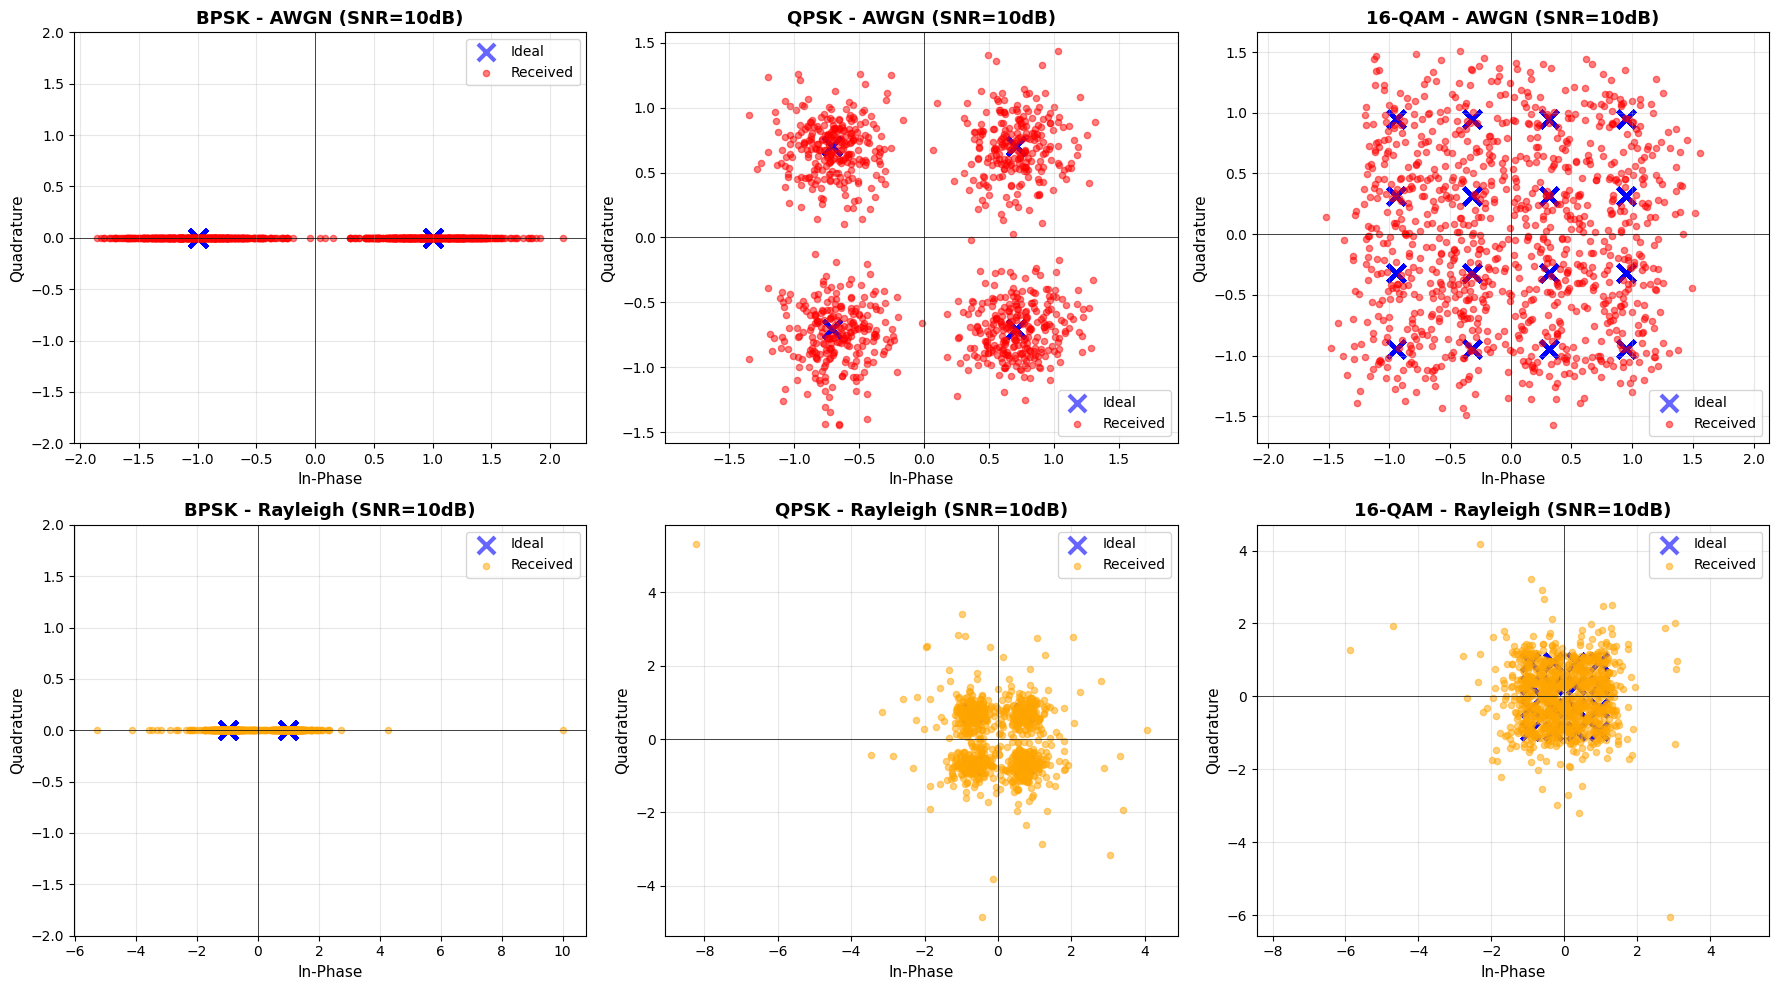

In [8]:
def plot_all_constellations(snr_db=10, num_symbols=1000):
    """
    Generate 2×3 grid of constellation diagrams
    
    Args:
        snr_db: SNR value for visualization
        num_symbols: Number of symbols to plot
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    bits = np.random.randint(0, 2, num_symbols * 4)
    
    # ==================== Row 1: AWGN Channel ====================
    
    # BPSK - AWGN
    tx_sym = bpsk_modulate(bits[:num_symbols])
    rx_sym = add_awgn(tx_sym, snr_db)
    axes[0, 0].scatter(tx_sym, np.zeros_like(tx_sym), c='blue', s=150, 
                       alpha=0.6, label='Ideal', marker='x', linewidths=3)
    axes[0, 0].scatter(rx_sym.real, np.zeros_like(rx_sym), c='red', s=20, 
                       alpha=0.5, label='Received')
    axes[0, 0].set_title(f'BPSK - AWGN (SNR={snr_db}dB)', fontsize=13, fontweight='bold')
    axes[0, 0].set_xlabel('In-Phase', fontsize=11)
    axes[0, 0].set_ylabel('Quadrature', fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].set_ylim(-2, 2)
    axes[0, 0].axhline(0, color='black', linewidth=0.5)
    axes[0, 0].axvline(0, color='black', linewidth=0.5)
    
    # QPSK - AWGN
    tx_sym = qpsk_modulate(bits[:num_symbols * 2])
    rx_sym = add_awgn(tx_sym, snr_db)
    axes[0, 1].scatter(tx_sym.real, tx_sym.imag, c='blue', s=150, 
                       alpha=0.6, label='Ideal', marker='x', linewidths=3)
    axes[0, 1].scatter(rx_sym.real, rx_sym.imag, c='red', s=20, 
                       alpha=0.5, label='Received')
    axes[0, 1].set_title(f'QPSK - AWGN (SNR={snr_db}dB)', fontsize=13, fontweight='bold')
    axes[0, 1].set_xlabel('In-Phase', fontsize=11)
    axes[0, 1].set_ylabel('Quadrature', fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].axis('equal')
    axes[0, 1].axhline(0, color='black', linewidth=0.5)
    axes[0, 1].axvline(0, color='black', linewidth=0.5)
    
    # 16-QAM - AWGN
    tx_sym = qam16_modulate(bits[:num_symbols * 4])
    rx_sym = add_awgn(tx_sym, snr_db)
    axes[0, 2].scatter(tx_sym.real, tx_sym.imag, c='blue', s=150, 
                       alpha=0.6, label='Ideal', marker='x', linewidths=3)
    axes[0, 2].scatter(rx_sym.real, rx_sym.imag, c='red', s=20, 
                       alpha=0.5, label='Received')
    axes[0, 2].set_title(f'16-QAM - AWGN (SNR={snr_db}dB)', fontsize=13, fontweight='bold')
    axes[0, 2].set_xlabel('In-Phase', fontsize=11)
    axes[0, 2].set_ylabel('Quadrature', fontsize=11)
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].legend(fontsize=10)
    axes[0, 2].axis('equal')
    axes[0, 2].axhline(0, color='black', linewidth=0.5)
    axes[0, 2].axvline(0, color='black', linewidth=0.5)
    
    # ==================== Row 2: Rayleigh Fading ====================
    
    # BPSK - Rayleigh
    tx_sym = bpsk_modulate(bits[:num_symbols])
    rx_sym = add_rayleigh_fading(tx_sym, snr_db)
    axes[1, 0].scatter(tx_sym, np.zeros_like(tx_sym), c='blue', s=150, 
                       alpha=0.6, label='Ideal', marker='x', linewidths=3)
    axes[1, 0].scatter(rx_sym.real, np.zeros_like(rx_sym), c='orange', s=20, 
                       alpha=0.5, label='Received')
    axes[1, 0].set_title(f'BPSK - Rayleigh (SNR={snr_db}dB)', fontsize=13, fontweight='bold')
    axes[1, 0].set_xlabel('In-Phase', fontsize=11)
    axes[1, 0].set_ylabel('Quadrature', fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].set_ylim(-2, 2)
    axes[1, 0].axhline(0, color='black', linewidth=0.5)
    axes[1, 0].axvline(0, color='black', linewidth=0.5)
    
    # QPSK - Rayleigh
    tx_sym = qpsk_modulate(bits[:num_symbols * 2])
    rx_sym = add_rayleigh_fading(tx_sym, snr_db)
    axes[1, 1].scatter(tx_sym.real, tx_sym.imag, c='blue', s=150, 
                       alpha=0.6, label='Ideal', marker='x', linewidths=3)
    axes[1, 1].scatter(rx_sym.real, rx_sym.imag, c='orange', s=20, 
                       alpha=0.5, label='Received')
    axes[1, 1].set_title(f'QPSK - Rayleigh (SNR={snr_db}dB)', fontsize=13, fontweight='bold')
    axes[1, 1].set_xlabel('In-Phase', fontsize=11)
    axes[1, 1].set_ylabel('Quadrature', fontsize=11)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].axis('equal')
    axes[1, 1].axhline(0, color='black', linewidth=0.5)
    axes[1, 1].axvline(0, color='black', linewidth=0.5)
    
    # 16-QAM - Rayleigh
    tx_sym = qam16_modulate(bits[:num_symbols * 4])
    rx_sym = add_rayleigh_fading(tx_sym, snr_db)
    axes[1, 2].scatter(tx_sym.real, tx_sym.imag, c='blue', s=150, 
                       alpha=0.6, label='Ideal', marker='x', linewidths=3)
    axes[1, 2].scatter(rx_sym.real, rx_sym.imag, c='orange', s=20, 
                       alpha=0.5, label='Received')
    axes[1, 2].set_title(f'16-QAM - Rayleigh (SNR={snr_db}dB)', fontsize=13, fontweight='bold')
    axes[1, 2].set_xlabel('In-Phase', fontsize=11)
    axes[1, 2].set_ylabel('Quadrature', fontsize=11)
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].legend(fontsize=10)
    axes[1, 2].axis('equal')
    axes[1, 2].axhline(0, color='black', linewidth=0.5)
    axes[1, 2].axvline(0, color='black', linewidth=0.5)
    
    plt.tight_layout()
    plt.savefig('All_Constellations.png', dpi=300, bbox_inches='tight')
    print("\nConstellation diagrams saved as 'All_Constellations.png'")
    plt.show()


plot_all_constellations(snr_db=10)

## Cell 9: Summary Report

Generate comprehensive performance analysis

In [9]:
def generate_complete_summary(snr_values, results):
    """
    Generate detailed performance summary
    
    Args:
        snr_values: Array of SNR values
        results: Dictionary containing BER results
    """
    print("\n" + "=" * 80)
    print(" " * 20 + "WIRELESS CHANNEL SIMULATION RESULTS")
    print("=" * 80)
    
    print(f"\nSimulation Parameters:")
    print(f"  - Number of Bits: 100,000 per test")
    print(f"  - SNR Range: {snr_values[0]} to {snr_values[-1]} dB (step: 2 dB)")
    print(f"  - Modulations: BPSK, QPSK, 16-QAM (Gray-coded)")
    print(f"  - Channels: AWGN, Rayleigh Fading (Perfect CSI)")
    print(f"  - Total Bits Transmitted: {len(snr_values) * 3 * 2 * 100000:,}")
    
    print("\n" + "=" * 80)
    print("AWGN CHANNEL PERFORMANCE:")
    print("=" * 80)
    
    test_snrs = [5, 10, 15]
    for test_snr in test_snrs:
        if test_snr in snr_values:
            idx = np.where(snr_values == test_snr)[0][0]
            print(f"\nAt SNR = {test_snr} dB:")
            print(f"  BPSK:   BER = {results['AWGN']['BPSK'][idx]:.2e} ({results['AWGN']['BPSK'][idx] * 100:.4f}%)")
            print(f"  QPSK:   BER = {results['AWGN']['QPSK'][idx]:.2e} ({results['AWGN']['QPSK'][idx] * 100:.4f}%)")
            print(f"  16-QAM: BER = {results['AWGN']['16-QAM'][idx]:.2e} ({results['AWGN']['16-QAM'][idx] * 100:.4f}%)")
    
    print("\n" + "=" * 80)
    print("RAYLEIGH FADING CHANNEL PERFORMANCE (Perfect CSI):")
    print("=" * 80)
    
    for test_snr in test_snrs:
        if test_snr in snr_values:
            idx = np.where(snr_values == test_snr)[0][0]
            print(f"\nAt SNR = {test_snr} dB:")
            print(f"  BPSK:   BER = {results['Rayleigh']['BPSK'][idx]:.2e} ({results['Rayleigh']['BPSK'][idx] * 100:.4f}%)")
            print(f"  QPSK:   BER = {results['Rayleigh']['QPSK'][idx]:.2e} ({results['Rayleigh']['QPSK'][idx] * 100:.4f}%)")
            print(f"  16-QAM: BER = {results['Rayleigh']['16-QAM'][idx]:.2e} ({results['Rayleigh']['16-QAM'][idx] * 100:.4f}%)")
    
    print("\n" + "=" * 80)

generate_complete_summary(snr_vals, all_results)


                    WIRELESS CHANNEL SIMULATION RESULTS

Simulation Parameters:
  - Number of Bits: 100,000 per test
  - SNR Range: 0 to 20 dB (step: 2 dB)
  - Modulations: BPSK, QPSK, 16-QAM (Gray-coded)
  - Channels: AWGN, Rayleigh Fading (Perfect CSI)
  - Total Bits Transmitted: 6,600,000

AWGN CHANNEL PERFORMANCE:

At SNR = 10 dB:
  BPSK:   BER = 8.20e-04 (0.0820%)
  QPSK:   BER = 8.10e-04 (0.0810%)
  16-QAM: BER = 7.80e-02 (7.7960%)

RAYLEIGH FADING CHANNEL PERFORMANCE (Perfect CSI):

At SNR = 10 dB:
  BPSK:   BER = 2.26e-02 (2.2620%)
  QPSK:   BER = 4.40e-02 (4.3980%)
  16-QAM: BER = 1.41e-01 (14.0670%)



---

## Conclusion

This simulation successfully demonstrates:

✓ **Digital Modulation Techniques:** BPSK, QPSK, and Gray-coded 16-QAM  
✓ **Wireless Channel Modeling:** AWGN and Rayleigh fading with Perfect CSI  
✓ **BER Performance Analysis:** Comprehensive Monte Carlo simulation  
✓ **Trade-offs:** Spectral efficiency vs power efficiency  

